In [5]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
from PIL import Image, ImageEnhance
from os import listdir
import imghdr
from skimage.transform import rotate, AffineTransform, warp
from skimage import filters
from torchvision import transforms
import cv2
import scipy
import random

In [ ]:
rmdir './Data_full/.ipynb_checkpoints'

In [78]:
#Load Data
# return array of images
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

# Convert png img array to array np arrays
def ImagesToArray(imgs):
  imgs_array = []
  for img in imgs:
    img_array = np.array(img)
    imgs_array.append(img_array)
  return imgs_array

# Reshape Images   
def shape600(x):
  reshaped_array = np.zeros((len(x), 600, 600, 3))
  for i, img in enumerate(x):
    x_pad_width = (600 - img.shape[0])//2
    y_pad_width = (600 - img.shape[1])//2
    reshaped_array[i,:,:,:] = np.pad(img, ((x_pad_width, x_pad_width + (img.shape[0])%2), (y_pad_width, y_pad_width+(img.shape[1]%2)), (0,0)), constant_values=img[0][0][0])
  return reshaped_array

# Normalize images
def Normalize(imgs):
  new_imgs = []
  for img in imgs:
      # flat_img = img.flatten()
      m = np.mean(img)
      std = np.std(img)
      img = (img-m)/std
      new_imgs.append(img)
  return new_imgs

# x is input image, sd is how much to blur
def blur(imgs, sd=1):
  filtered_img = np.zeros((imgs.shape[0], 600, 600, 3))
  for i in range(imgs.shape[0]):
    filtered_img[i,:,:,:] = skimage.filters.gaussian(imgs[i,:,:,:], sigma=sd)
    #filtered_img.save('./Filter_gaussian/img_' + i + '_gaussianfilt.png')
  return filtered_img

def Scale(imgs):
  scaled_images = np.zeros((len(imgs), 600, 600, 3))
  for i, img in enumerate(imgs):
    # ratio = random.randrange(.2, .5, .1)
    ratio = random.choice([0.1, 0.2, 0.3, 0.4])
    x = int(ratio * 600 / 2)
    scaled = img[x:600-x, x:600-x]
    # scaled = cv2.imread(scaled)
    res = cv2.resize(scaled, dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
    scaled_images[i] = res
  return scaled_images
    # final.save('./Crop/img_' + str(i) + '_scale.png')

def Rotate30(imgs): 
  rot30_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_dir = random.choice([-1, 1])
    new_img = rotate(img, rand_dir * 30) 
    rot30_imgs[i, :] = new_img
  return rot30_imgs

def VerticalFlip(imgs): 
  flip_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    new_img = np.fliplr(img)
    flip_imgs[i, :, :, :] = new_img
  return flip_imgs

def Translation(imgs): 
  trans_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_x = random.randrange(-150, 150, 50)
    rand_y = random.randrange(-150, 150, 50)
    transform = AffineTransform(translation=(rand_x,rand_y))
    new_img = warp(img,transform, mode="constant")  
    trans_imgs[i, :] = new_img
  return trans_imgs

# load png_images
path = "./Data_full/"

# images in an array named imgs
imgs, labels = loadImages(path)

# Step 1 convert png_images to np arrays
imgs_array_before = ImagesToArray(imgs)

def Augment(imgs_array_before, labels):
  # Step 2 Normalize images
  imgs_array_normalize = Normalize(imgs_array_before)

  # Step 3 Reshape the images
  imgs_array_reshaped = shape600(imgs_array_normalize)

  # Step 4 Blur the images
  blurred_imgs = blur(imgs_array_reshaped, 10)

  # Step 5 Scale the images
  scaled_imgs = Scale(imgs_array_reshaped)

  # Step 6 Flip the images
  flipped_imgs = VerticalFlip(imgs_array_reshaped)

  # Step 7 Add translation to images
  translated_imgs = Translation(imgs_array_reshaped)

  # Step 8 Rotate 30 Degrees
  rotated30_imgs = Rotate30(imgs_array_reshaped)

  # Step 10 combine all augmented images to np array of shape((num_augmentations + 1) * num_images, 600, 600, 3)
  final_imgs_temp = np.concatenate((imgs_array_reshaped, blurred_imgs, scaled_imgs, translated_imgs, flipped_imgs, rotated30_imgs), 0)
  labels_temp = np.concatenate((labels, labels, labels, labels, labels, labels), 0)
  #print(final_imgs_temp.shape)
  # np.save('../FinalImages/imgs' + str(i) + '.npy', final_imgs_temp)
  # Show the progression of images for each step
  # fig, ax = plt.subplots(1, 11, figsize=(15,10))
  # ax[0].imshow(imgs_array_before[0]) # Step 1
  # ax[1].imshow(imgs_array_normalize[0]) # Step 2
  # ax[2].imshow(imgs_array_reshaped[0]) # Step 3
  # ax[3].imshow(blurred_imgs[0]) # Step 4
  # ax[4].imshow(scaled_imgs[0]) # Step 5
  # ax[5].imshow(light_imgs[0]) # Step 6
  # ax[6].imshow(dark_imgs[0]) # Step 6
  # ax[7].imshow(flipped_imgs[0]) # Step 7
  # ax[8].imshow(translated_imgs[0]) # Step 8
  # ax[9].imshow(rotated30_imgs[0]) # Step 9
  # ax[10].imshow(rotatedNeg30_imgs[0]) # Step 9
  return final_imgs_temp, labels_temp


In [39]:
final_imgs = np.empty([0, 600, 600, 3])
final_labels = np.empty([0])
n = int(130/65)
for i in range(n):
  [final_imgs_temp, labels_temp] = Augment(imgs_array_before[i * 65:(i + 1) * 65], labels[i * 65:(i + 1) * 65])
  final_imgs = np.concatenate((final_imgs, final_imgs_temp), 0)
  final_labels = np.concatenate((final_labels, labels_temp))
  
  if (n % 10 == 0):
    print(n)

print(final_imgs.shape)
print(final_labels.shape)
np.save('./FinalImages/imgs.npy', final_imgs)
np.save('./FinalImages/labels.npy', final_labels)

/Users/aidanaug/Library/Python/3.8/lib/python/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


(780, 600, 600, 3)
(780,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.0


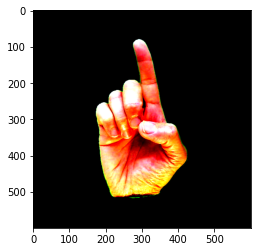

In [40]:
augmented_data = np.load("./FinalImages/imgs.npy")
labels = np.load("./FinalImages/labels.npy")
plt.imshow(augmented_data[1,:,:])
print(labels[1])

In [66]:
## Model Implementation
import sys
import csv
import os
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
from skimage.transform import rotate
from sklearn.model_selection import train_test_split

In [67]:
class AlexNet(torch.nn.Module):
    ### TODO Implement your model's structure and input/filter/output dimensions
    def __init__(self, input_height=600, input_width=600, n_classes=27, channels=3):
        super().__init__()

        # Initialize the parameters of the model
        self.input_height = input_height
        self.input_width = input_width
        self.n_classes = n_classes
        self.channels = channels

        # AlexNet Implementation; Same Structure with different outputs die to input
        self.model_convolution = nn.Sequential(
            # INPUT: 600x600x3
            nn.Conv2d(in_channels=channels,out_channels=96, kernel_size=12, stride=4), # output: 148x148
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=4, stride=2), #73x73
            nn.ReLU(),
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5, padding=2), #73x73
            nn.ReLU(),
            nn.AvgPool2d(3,3), #36x36
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3, padding=1), #36x36
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3, padding=1), #36x36
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3, padding=1), #36x36
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=6,stride=2), #16x16x256
            nn.Conv2d(256,256, 12, padding=1, stride=2) #4x4x256
        )

        # The dense network architecture. Assumes input has 4096 nodes, or 4x4x256
        self.model_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, n_classes)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0],self.channels, self.input_height, self.input_width)
        x = self.model_convolution(x)
        x = self.model_dense(x)
        return x
    
        

In [80]:

def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
    """Calculate the simple accuracy given two numpy vectors, each with int values
    corresponding to each class.

    Args:
        y (np.ndarray): actual value
        y_hat (np.ndarray): predicted value

    Returns:
        np.float64: accuracy
    """
    ### TODO Implement accuracy function
    N = len(y)   
    number_correct = N - np.count_nonzero(y - y_hat)
    accuracy = number_correct / N
    return accuracy


def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
    """Given a model, training data and its associated labels, calculate the simple accuracy when the 
    model is applied to the training dataset.
    This function is meant to be run during training to evaluate model training accuracy during training.

    Args:
        model (pytorch model): model class object.
        train_data (np.ndarray): training data
        train_labels (np.ndarray): training labels

    Returns:
        np.float64: simple accuracy
    """
    idxs = np.random.choice(len(train_data), len(train_data)//2, replace=False)
    x = torch.from_numpy(train_data[idxs].astype(np.float32))
    y = torch.from_numpy(train_labels[idxs].astype(np.int))
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(train_labels[idxs], y_pred.numpy()), loss.item()


def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
    """Given a model, a validation dataset and its associated labels, calcualte the simple accuracy when the
    model is applied to the validation dataset.
    This function is meant to be run during training to evaluate model validation accuracy.

    Args:
        model (pytorch model): model class obj
        dev_data (np.ndarray): validation data
        dev_labels (np.ndarray): validation labels

    Returns:
        np.float64: simple validation accuracy
    """
    x = torch.from_numpy(dev_data.astype(np.float32))
    y = torch.from_numpy(dev_labels.astype(np.int))
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(dev_labels, y_pred.numpy()), loss.item()

In [81]:
LEARNING_RATE = 0.01
BATCH_SIZE = 100
EPOCHS = 50
HEIGHT = 600
WIDTH = 600
CHANNELS = 3

model = AlexNet()

### TODO (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# load png_images
path = "./Data_full/"

# images in an array named imgs
imgs, labels = loadImages(path)

labels = np.asarray(labels)

## Preprocess Images using online package
imgs_array_before = ImagesToArray(imgs)

preprocess = transforms.Compose([
  transforms.Resize(600),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
imgs_array_reshaped = preprocess(imgs_array_before)

############################

## Preprocess images Using our functions
# imgs_array_normalize = Normalize(imgs_array_before)
# imgs_array_reshaped = shape600(imgs_array_normalize)

## Use Augmented Data
# augmented_data = np.load("./FinalImages/imgs.npy")
# labels = np.load("./FinalImages/labels.npy")

############################

## Actually create the train and test dev splits. Flatten before use.
data_train, data_dev, labels_train, labels_dev = train_test_split(imgs_array_reshaped, labels, test_size=0.20, random_state=42)
flat_train_imgs = np.reshape(data_train, (data_train.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_train_imgs = np.swapaxes(flat_train_imgs, 1, 2)
flat_dev_imgs = np.reshape(data_dev, (data_dev.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_dev_imgs = np.swapaxes(flat_dev_imgs, 1, 2)


for step in range(EPOCHS):
    i = np.random.choice(flat_train_imgs.shape[0], size=BATCH_SIZE, replace=False)
    x = torch.from_numpy(flat_train_imgs[i].astype(np.float32))
    y = torch.from_numpy(labels_train[i].astype(np.int))
    
    
    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = F.cross_entropy(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # log model performance every 10 epochs
    if step % 10 == 0:
        train_acc, train_loss = approx_train_acc_and_loss(model, flat_train_imgs, labels_train)
        dev_acc, dev_loss = dev_acc_and_loss(model, flat_dev_imgs, labels_dev)
        step_metrics = {
            'step': step, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }

        print(f"On step {step}:\tTrain loss {train_loss}\t|\tDev acc is {dev_acc}")
        

print("Training completed, saving model with name AlexNet")


/var/folders/nt/hd11kqnj1bz1qm99qnprwhrr0000gn/T/ipykernel_75543/2929041317.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = torch.from_numpy(labels_train[i].astype(np.int))
/var/folders/nt/hd11kqnj1bz1qm99qnprwhrr0000gn/T/ipykernel_75543/1545596795.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

On step 0:	Train loss 2483695.75	|	Dev acc is 0.046153846153846156
On step 10:	Train loss 4.6942315101623535	|	Dev acc is 0.038461538461538464
On step 20:	Train loss 3.2564868927001953	|	Dev acc is 0.015384615384615385


In [59]:
import torch
import torchvision.transforms as transforms
from PIL import Image

from alexnet_pytorch import AlexNet

# Open image
input_image = Image.open("img.jpg")

# Preprocess image
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

# Load class names
labels_map = json.load(open("labels_map.txt"))
labels_map = [labels_map[str(i)] for i in range(1000)]

# Classify with AlexNet
model = AlexNet.from_pretrained("alexnet")
model.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
  input_batch = input_batch.to("cuda")
  model.to("cuda")

with torch.no_grad():
  logits = model(input_batch)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()

print("-----")
for idx in preds:
  label = labels_map[idx]
  prob = torch.softmax(logits, dim=1)[0, idx].item()
  print(f"{label:<75} ({prob * 100:.2f}%)")

ModuleNotFoundError: No module named 'alexnet_pytorch'